# Fishing Detection: Feature engineering, protected areas

In [1]:
import sys
from pathlib import Path
ROOT = Path().resolve().parent
sys.path.insert(0, str(ROOT / "src"))


## Charger et inspecter les MPAs

In [2]:
from features.mpa.loader import MPALoader
from features.mpa.utils  import MPAQuery
from config import WDPA_GDB, WDPA_GDB_LAYER, WDPA_CSV

loader = MPALoader(
    gdb_path   = WDPA_GDB,
    layer_name = WDPA_GDB_LAYER,
    csv_path   = WDPA_CSV
)
query = MPAQuery(loader)

mpa_gdf = loader.gdf
print("MPAs chargées :", len(mpa_gdf))


MPAs chargées : 16491


## Charger échantillon AIS

In [3]:
import pandas as pd, geopandas as gpd
ais = pd.read_csv(ROOT / "data/samples/ais_sample.csv")
gdf_ais = gpd.GeoDataFrame(
    ais, 
    geometry=gpd.points_from_xy(ais.lon, ais.lat),
    crs="EPSG:4326"
)


## Vectoriser le join

In [4]:
gdf_enriched = gpd.sjoin(
    gdf_ais,
    mpa_gdf[["WDPAID","PA_DEF","NO_TAKE","geometry"]],
    how="left",
    predicate="within"
).drop(columns="index_right")


## Calculer la distance

In [5]:
gdf_enriched["dist_to_mpa"] = gdf_enriched.geometry.apply(
    lambda p: query.distance_to_nearest_mpa(p.y, p.x)
)


C:\Users\oscar\Desktop\projets_oscar\illegal-fishing-detection\src\feature\mpa_module\utils.py:69: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return float(self.gdf.distance(pt).min())


## Visualiser

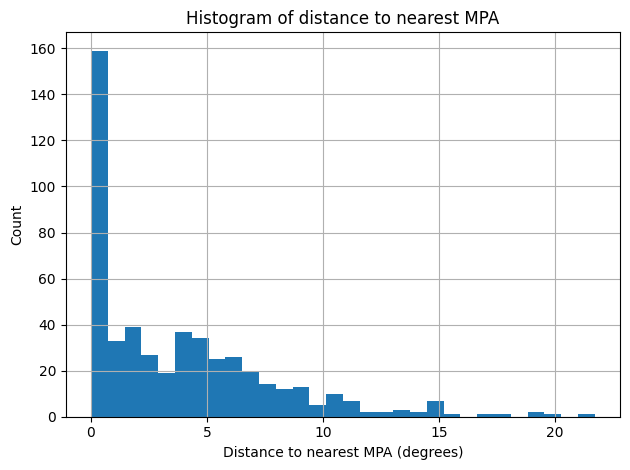

In [10]:
import matplotlib.pyplot as plt
import folium

# --- 0) Assure-toi que gdf_enriched a bien les colonnes nécessaires ---
if "in_mpa" not in gdf_enriched.columns:
    # Point-to-point : la colonne WDPAID vient du spatial join
    gdf_enriched["in_mpa"] = gdf_enriched["WDPAID"].notna()

# (Re)calcule éventuellement dist_to_mpa si elle manquait aussi
if "dist_to_mpa" not in gdf_enriched.columns:
    from feature.mpa_module.utils import MPAQuery
    # il faut un 'loader' défini plus haut dans le notebook
    query = MPAQuery(loader)
    gdf_enriched["dist_to_mpa"] = gdf_enriched.geometry.apply(
        lambda p: query.distance_to_nearest_mpa(p.y, p.x)
    )

# --- 1) Histogramme de dist_to_mpa ---
plt.figure()
gdf_enriched["dist_to_mpa"].hist(bins=30)
plt.xlabel("Distance to nearest MPA (degrees)")
plt.ylabel("Count")
plt.title("Histogram of distance to nearest MPA")
plt.tight_layout()
plt.show()

# --- 2) Carte Folium colorée par in_mpa ---
minx, miny, maxx, maxy = gdf_enriched.geometry.total_bounds
m = folium.Map(
    location=[(miny + maxy) / 2, (minx + maxx) / 2],
    zoom_start=4
)

for geom, inside in zip(gdf_enriched.geometry, gdf_enriched["in_mpa"]):
    folium.CircleMarker(
        location=[geom.y, geom.x],
        radius=3,
        color="red" if inside else "blue",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Enfin, affiche la carte
m
